In [1]:
import itertools
import os
import shutil
from functools import partial
from time import time

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from estimagic.batch_evaluators import joblib_batch_evaluator
from sid import get_colors, get_msm_func, get_simulate_func
from sid.msm import get_diag_weighting_matrix

from src.calculate_moments import (
    smoothed_outcome_per_hundred_thousand_rki,
    smoothed_outcome_per_hundred_thousand_sim,
)
from src.config import BLD, SRC
from src.create_initial_states.create_initial_conditions import (  # noqa
    create_initial_conditions,
)
from src.manfred.shared import hash_array
from src.policies.combine_policies_over_periods import (
    get_enacted_policies_of_2021,
    get_october_to_christmas_policies,
)
from src.policies.policy_tools import combine_dictionaries
from src.simulation.main_specification import (
    SCENARIO_START,
    SIMULATION_DEPENDENCIES,
    load_simulation_inputs,
)

SAVED_COLUMNS = {
    "initial_states": ["age_group_rki"],
    "disease_states": ["newly_infected"],
    "time": ["date"],
    "other": [
        "new_known_case",
        # "virus_strain",
    ],
}


plt.rcParams.update(
    {
        "axes.spines.right": False,
        "axes.spines.top": False,
        "legend.frameon": False,
    }
)

print(SCENARIO_START.date())
import warnings

warnings.simplefilter("ignore")

MODE = "fall"

2021-04-30


# Load the fall and spring simulation inputs

In [2]:
# spring

spring_start_date = pd.Timestamp("2021-02-05")
spring_end_date = spring_start_date + pd.Timedelta(weeks=1)  ### 4
spring_init_start = spring_start_date - pd.Timedelta(31, unit="D")
print(spring_init_start.date(), spring_end_date.date())
spring_init_end = spring_start_date - pd.Timedelta(1, unit="D")

virus_shares, spring_kwargs = load_simulation_inputs(
    SIMULATION_DEPENDENCIES, spring_init_start, spring_end_date
)
# we don't want to parse the "old" params
spring_kwargs.pop("params")

full_spring_simulate_inputs = {
    "duration": {"start": spring_start_date, "end": spring_end_date},
    "initial_conditions": create_initial_conditions(
        start=spring_init_start,
        end=spring_init_end,
        seed=3930,
        reporting_delay=5,
        virus_shares=virus_shares,
    ),
    "contact_policies": get_enacted_policies_of_2021(
        contact_models=spring_kwargs["contact_models"],
        scenario_start=SCENARIO_START,
        work_hygiene_multiplier=0.8,
    ),
    "saved_columns": SAVED_COLUMNS,
    **spring_kwargs,
}

2021-01-05 2021-02-12


In [3]:
# fall

fall_start_date = pd.Timestamp("2020-09-01")
fall_init_start = fall_start_date - pd.Timedelta(31, unit="D")
fall_end_date = pd.Timestamp("2020-12-20")
print(fall_init_start.date(), fall_end_date.date())
fall_init_end = fall_start_date - pd.Timedelta(1, unit="D")

virus_shares, fall_kwargs = load_simulation_inputs(
    SIMULATION_DEPENDENCIES,
    fall_init_start,
    fall_end_date,
)
# we don't want to parse the "old" params
fall_kwargs.pop("params")


full_fall_simulate_inputs = {
    "duration": {"start": fall_start_date, "end": fall_end_date},
    "initial_conditions": create_initial_conditions(
        start=fall_init_start,
        end=fall_init_end,
        seed=344490,
        reporting_delay=5,
        virus_shares=virus_shares,
    ),
    "contact_policies": get_october_to_christmas_policies(
        contact_models=fall_kwargs["contact_models"],
    ),
    "saved_columns": SAVED_COLUMNS,
    **fall_kwargs,
}

2020-08-01 2020-12-20


# Build the criterion

In [4]:
def _simulate_wrapper(params, simulate):
    return simulate(params)["time_series"]


def build_and_evaluate_msm_func(params, seed, prefix, simulate_kwargs):
    params_hash = hash_array(params["value"].to_numpy())
    path = SRC / "exploration" / f"{prefix}_{params_hash}_{os.getpid()}"

    simulate = get_simulate_func(
        **simulate_kwargs,
        params=params,
        path=path / "fall_part",
        seed=seed,
    )

    calc_moments = {
        "infections_by_age_group": partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="new_known_case",
            groupby="age_group_rki",
        ),
    }

    # empirical moments
    rki_data = pd.read_pickle(BLD / "data" / "processed_time_series" / "rki.pkl")
    rki_data = rki_data.loc[
        simulate_kwargs["duration"]["start"] : simulate_kwargs["duration"]["end"]
    ]
    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )
    empirical_moments = {
        "infections_by_age_group": smoothed_outcome_per_hundred_thousand_rki(
            df=rki_data,
            outcome="newly_infected",
            groupby="age_group_rki",
            window=7,
            min_periods=1,
            group_sizes=age_group_info["n"],
        )
    }

    # weighting matrix
    age_weights = age_group_info["weight"].to_dict()

    temp = empirical_moments["infections_by_age_group"].to_frame().copy(deep=True)
    temp["age_group"] = temp.index.get_level_values(1)
    temp["weights"] = temp["age_group"].replace(age_weights)

    weights = {"infections_by_age_group": temp["weights"]}

    weight_mat = get_diag_weighting_matrix(
        empirical_moments=empirical_moments,
        weights=weights,
    )

    msm_func = get_msm_func(
        simulate=partial(_simulate_wrapper, simulate=simulate),
        calc_moments=calc_moments,
        empirical_moments=empirical_moments,
        replace_nans=lambda x: x * 1,
        weighting_matrix=weight_mat,
    )

    res = msm_func(params)
    shutil.rmtree(path)
    return res


# params, seed, prefix, simulate_kwargs, policies, start_date,
# end_date, initial_conditions


def build_and_evaluate_combined_msm_func(
    params,
    seed,
    prefix,
    full_fall_simulate_inputs,
    full_spring_simulate_inputs,
    saved_columns,
):
    fall_msm_res = build_and_evaluate_msm_func(
        params=params,
        seed=seed,
        prefix=prefix + "_fall",
        simulate_kwargs=full_fall_simulate_inputs,
    )
    spring_msm_res = build_and_evaluate_msm_func(
        params=params,
        seed=seed + 100_000,
        prefix=prefix + "_spring",
        simulate_kwargs=full_spring_simulate_inputs,
    )

    # get weights of parts
    length_fall = _get_period_length(full_fall_simulate_inputs)
    length_spring = _get_period_length(full_spring_simulate_inputs)
    combined_length = length_fall + length_spring
    fall_weight = length_fall / combined_length
    spring_weight = length_spring / combined_length

    # combine results
    weighted_value = (
        fall_weight * fall_msm_res["value"] + spring_weight * spring_msm_res["value"]
    )

    emp_mom_list = [
        fall_msm_res["empirical_moments"],
        spring_msm_res["empirical_moments"],
    ]
    sim_mom_list = [
        fall_msm_res["simulated_moments"],
        spring_msm_res["simulated_moments"],
    ]

    res = {
        "value": weighted_value,
        "empirical_moments": emp_mom_list,
        "simulated_moments": sim_mom_list,
    }
    return res


def _get_period_length(inputs):
    return inputs["duration"]["end"] - inputs["duration"]["start"]


if MODE == "combined":
    pmsm = partial(
        build_and_evaluate_combined_msm_func,
        prefix="gridsearch",
        full_fall_simulate_inputs=full_fall_simulate_inputs,
        full_spring_simulate_inputs=full_spring_simulate_inputs,
        saved_columns=SAVED_COLUMNS,
    )
elif MODE == "fall":
    pmsm = partial(
        build_and_evaluate_msm_func,
        prefix="gridsearch",
        simulate_kwargs=full_fall_simulate_inputs,
    )
elif MODE == "spring":
    pmsm = partial(
        build_and_evaluate_msm_func,
        prefix="gridsearch",
        simulate_kwargs=full_spring_simulate_inputs,
    )


def reshape_flat_list(flat_list, n_rows, n_cols):
    assert n_rows * n_cols == len(flat_list)
    reshaped = []
    entries = iter(flat_list)
    for r in range(n_rows):
        row = []
        for c in range(n_cols):
            row.append(next(entries))
        reshaped.append(row)
    return reshaped


def visualize_msm_evaluations(msm_evaluations, key="infections_by_age_group", period=0):
    """Visualize a list of outputs of the msm criterion function.

    The plot contains the mean moments over all list elements as well
    as the individual lines.

    All moments are assumed to be disaggregated by age groups.

    Args:
        msm_evaluations (list): List of outputs of the msm criterion function.
        key (str): Used to select an element from the dictionaries of empirical
            and simulated moments.

    """
    if isinstance(msm_evaluations, dict):
        msm_evaluations = [msm_evaluations]

    colors = get_colors(palette="categorical", number=2)

    fig, axes = plt.subplots(nrows=7, figsize=(8, 16), sharex=False)

    if isinstance(msm_evaluations[0]["empirical_moments"], list):
        is_list_result = True
    else:
        is_list_result = False

    if is_list_result:
        emp_mom_sr = msm_evaluations[0]["empirical_moments"][period][key]
    else:
        emp_mom_sr = msm_evaluations[0]["empirical_moments"][key]

    emp_mom = _unstack_moment_series_with_flattened_index(emp_mom_sr)

    if is_list_result:
        sim_moms = [res["simulated_moments"][period][key] for res in msm_evaluations]
    else:
        sim_moms = [res["simulated_moments"][key] for res in msm_evaluations]

    mean_sim_mom = _unstack_moment_series_with_flattened_index(
        pd.concat(sim_moms, axis=1).mean(axis=1)
    )
    emp_mom = emp_mom.loc[mean_sim_mom.index]

    age_groups = ["0-4", "5-14", "15-34", "35-59", "60-79", "80-100"]

    for age_group, ax in zip(age_groups, axes[1:]):
        for mom in sim_moms:
            mom_df = _unstack_moment_series_with_flattened_index(mom)
            sns.lineplot(
                x=mom_df.index,
                y=mom_df[age_group],
                color=colors[0],
                alpha=0.4,
                linewidth=0.8,
                ax=ax,
            )
        sns.lineplot(
            x=mean_sim_mom.index,
            y=mean_sim_mom[age_group],
            label="simulated",
            color=colors[0],
            ax=ax,
            linewidth=2.5,
        )

        sns.lineplot(
            x=emp_mom.index,
            y=emp_mom[age_group],
            label="empirical",
            color=colors[1],
            ax=ax,
            linewidth=2.5,
        )
        ax.set_title(f"Goodness of Fit: {age_group}")
        ax.set_ylabel("Infections per 100 000")

    # add overall fitness plot
    ax = axes[0]

    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )
    age_weights = age_group_info["weight"]

    aggregated_emp_mom = (emp_mom * age_weights).sum(axis=1)

    mean_agg_sim_mom = (
        _unstack_moment_series_with_flattened_index(
            pd.concat(sim_moms, axis=1).mean(axis=1)
        )
        * age_weights
    ).sum(axis=1)

    agg_sim_moms = [
        (_unstack_moment_series_with_flattened_index(mom) * age_weights).sum(axis=1)
        for mom in sim_moms
    ]

    for mom in agg_sim_moms:

        sns.lineplot(
            x=mom.index,
            y=mom,
            color=colors[0],
            alpha=0.4,
            linewidth=0.8,
            ax=ax,
        )

    sns.lineplot(
        x=aggregated_emp_mom.index,
        y=aggregated_emp_mom,
        label="empirical",
        color=colors[1],
        ax=ax,
        linewidth=2.5,
    )

    sns.lineplot(
        x=mean_agg_sim_mom.index,
        y=mean_agg_sim_mom,
        label="simulated",
        color=colors[0],
        ax=ax,
        linewidth=2.5,
    )
    ax.set_title("Overall Goodness of Fit")
    ax.set_ylabel("Infections per 100 000")

    for ax in axes:
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))

    fig.tight_layout()
    return fig, ax


def _unstack_moment_series_with_flattened_index(sr):
    """Unstack a moment series with flattene index into a DataFrame.

    The columns of the DataFrame are the age groups. The index of
    the DataFrame is the date.

    """
    sr = sr.copy()
    sr.name = "value"
    df = sr.to_frame()
    df["date"] = list(map(lambda x: x.split("'", 2)[1], df.index))
    df["date"] = pd.to_datetime(df["date"])
    df["group"] = list(map(lambda x: x.rsplit(",", 1)[1].strip("') "), df.index))
    df.set_index(["date", "group"], inplace=True)
    return df["value"].unstack()

# Params

In [5]:
params = pd.read_pickle(BLD / "params.pkl")
params.loc[("virus_strain", "base_strain", "factor")] = 1.0
params.loc[("virus_strain", "b117", "factor")] = 1.67

params.loc["infection_prob"]

# using loc and index is necessary for later assignments to work
hh_probs = params.loc[[("infection_prob", "households", "households")]].index
school_probs = params.loc[
    [
        ("infection_prob", "educ_school_0", "educ_school_0"),
        ("infection_prob", "educ_school_1", "educ_school_1"),
        ("infection_prob", "educ_school_2", "educ_school_2"),
    ]
].index

young_educ_probs = params.loc[
    [
        ("infection_prob", "educ_preschool_0", "educ_preschool_0"),
        ("infection_prob", "educ_nursery_0", "educ_nursery_0"),
    ]
].index

work_probs = params.loc[
    [
        ("infection_prob", "work_non_recurrent", "work_non_recurrent"),
        ("infection_prob", "work_recurrent_daily", "work_recurrent_daily"),
        ("infection_prob", "work_recurrent_weekly_0", "work_recurrent_weekly_0"),
        ("infection_prob", "work_recurrent_weekly_1", "work_recurrent_weekly_1"),
        ("infection_prob", "work_recurrent_weekly_2", "work_recurrent_weekly_2"),
        ("infection_prob", "work_recurrent_weekly_3", "work_recurrent_weekly_3"),
        ("infection_prob", "work_recurrent_weekly_4", "work_recurrent_weekly_4"),
        ("infection_prob", "work_recurrent_weekly_5", "work_recurrent_weekly_5"),
        ("infection_prob", "work_recurrent_weekly_6", "work_recurrent_weekly_6"),
        ("infection_prob", "work_recurrent_weekly_7", "work_recurrent_weekly_7"),
        ("infection_prob", "work_recurrent_weekly_8", "work_recurrent_weekly_8"),
        ("infection_prob", "work_recurrent_weekly_9", "work_recurrent_weekly_9"),
        ("infection_prob", "work_recurrent_weekly_10", "work_recurrent_weekly_10"),
        ("infection_prob", "work_recurrent_weekly_11", "work_recurrent_weekly_11"),
        ("infection_prob", "work_recurrent_weekly_12", "work_recurrent_weekly_12"),
        ("infection_prob", "work_recurrent_weekly_13", "work_recurrent_weekly_13"),
    ]
].index

other_probs = params.loc[
    [
        ("infection_prob", "other_non_recurrent", "other_non_recurrent"),
        ("infection_prob", "other_recurrent_daily", "other_recurrent_daily"),
        ("infection_prob", "other_recurrent_weekly_0", "other_recurrent_weekly_0"),
        ("infection_prob", "other_recurrent_weekly_1", "other_recurrent_weekly_1"),
        ("infection_prob", "other_recurrent_weekly_2", "other_recurrent_weekly_2"),
        ("infection_prob", "other_recurrent_weekly_3", "other_recurrent_weekly_3"),
    ]
].index

prob_types = [hh_probs, school_probs, young_educ_probs, work_probs, other_probs]

free_probs = [probs[0] for probs in prob_types]


params.loc[other_probs, "value"] = 0.16  # Done
params.loc[young_educ_probs, "value"] = 0.005
params.loc[school_probs, "value"] = 0.01
params.loc[work_probs, "value"] = 0.15
params.loc[hh_probs] = 0.095
params.loc[free_probs]

value
category       subcategory         name                      
infection_prob households          households           0.095
               educ_school_0       educ_school_0        0.010
               educ_preschool_0    educ_preschool_0     0.005
               work_non_recurrent  work_non_recurrent   0.150
               other_non_recurrent other_non_recurrent  0.160

In [6]:
loc = params.query("category == 'cd_symptoms_true' & subcategory == '80-100'").index
params.loc[loc, "value"] = [0.25, 0.375, 0.375]
params.loc[loc]

value
category         subcategory name       
cd_symptoms_true 80-100      -1    0.250
                              1    0.375
                              2    0.375

In [23]:
locs = hh_probs
lb = 0.095
ub = 0.095
n_points = 6

seeds = [
    1_000_000,
    2_000_000,
    3_000_000,
]

n_cores = 18

grid = np.linspace(lb, ub, n_points)
arguments = []
for point, seed in itertools.product(grid, seeds):
    p = params.copy(deep=True)
    p.loc[locs, "value"] = point
    arguments.append({"params": p, "seed": seed})


results = joblib_batch_evaluator(
    func=pmsm,
    arguments=arguments,
    n_cores=n_cores,
    unpack_symbol="**",
)
reshaped_results = reshape_flat_list(results, n_points, len(seeds))

array([0.095])

In [8]:
avg_values = []
for row in reshaped_results:
    values = [res["value"] for res in row]
    avg_values.append(np.mean(values))

best_grid_index = np.argmin(avg_values)

<AxesSubplot:>

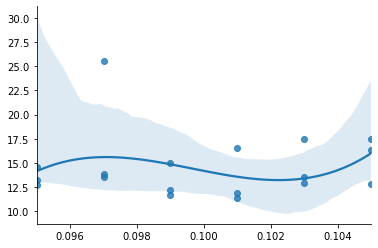

In [9]:
sns.regplot(
    np.repeat(grid, len(seeds)),
    [res["value"] for res in results],
    order=3,
)

In [10]:
grid

array([0.095, 0.097, 0.099, 0.101, 0.103, 0.105])

In [19]:
ix = 2
grid[ix]

0.099

In [20]:
avg_values[ix]

12.964555967306552

In [21]:
best_grid_index

2

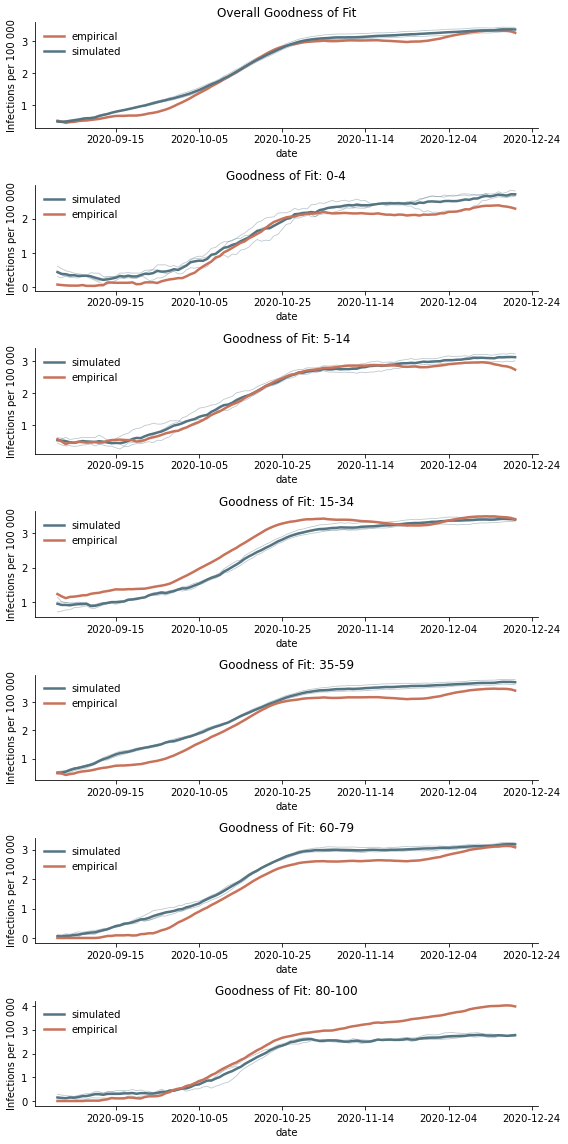

In [22]:
fig, ax = visualize_msm_evaluations(reshaped_results[ix], period=0)

In [15]:
fig.savefig("log_fitness_plot.png")

In [16]:
from os import listdir

listdir(BLD / "data" / "raw_time_series")

['vaccinations.yaml',
 'vaccination_deliveries.yaml',
 'vaccinations_with_reason.yaml',
 '2021_DE_Region_Mobility_Report.csv',
 'google_mobility.zip',
 'test_distribution.yaml',
 'rki.yaml',
 'rki.csv',
 'test_distribution.xlsx',
 '2020_DE_Region_Mobility_Report.csv',
 'test_statistics.yaml',
 'vaccination_deliveries.tsv',
 'google_mobility.yaml',
 'vaccinations.xlsx',
 'test_statistics.xlsx',
 'vaccinations_with_reason.tsv']

In [17]:
df = pd.read_csv(
    BLD / "data" / "raw_time_series" / "2020_DE_Region_Mobility_Report.csv"
)
df = df[df["sub_region_1"].isnull()]
df = df.set_index("date")
wm = 1 + df["workplaces_percent_change_from_baseline"] / 100
wm = wm.rolling(min_periods=1, window=7).mean()
df["work_multiplier"] = wm
df = df.loc["2020-08-01":"2020-12-15"]
df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,work_multiplier
date,,,,,,,,,,,,,,,
2020-08-01,DE,Germany,NaN,NaN,NaN,NaN,NaN,ChIJa76xwh5ymkcRW-WRjmtd6HU,-19,-8.0,156.0,-6.0,-4,-2,0.762857
2020-08-02,DE,Germany,NaN,NaN,NaN,NaN,NaN,ChIJa76xwh5ymkcRW-WRjmtd6HU,-5,35.0,89.0,-7.0,1,-1,0.761429
2020-08-03,DE,Germany,NaN,NaN,NaN,NaN,NaN,ChIJa76xwh5ymkcRW-WRjmtd6HU,6,2.0,114.0,-21.0,-35,5,0.758571
2020-08-04,DE,Germany,NaN,NaN,NaN,NaN,NaN,ChIJa76xwh5ymkcRW-WRjmtd6HU,5,0.0,143.0,-20.0,-34,6,0.755714
2020-08-05,DE,Germany,NaN,NaN,NaN,NaN,NaN,ChIJa76xwh5ymkcRW-WRjmtd6HU,6,-2.0,180.0,-19.0,-33,4,0.754286


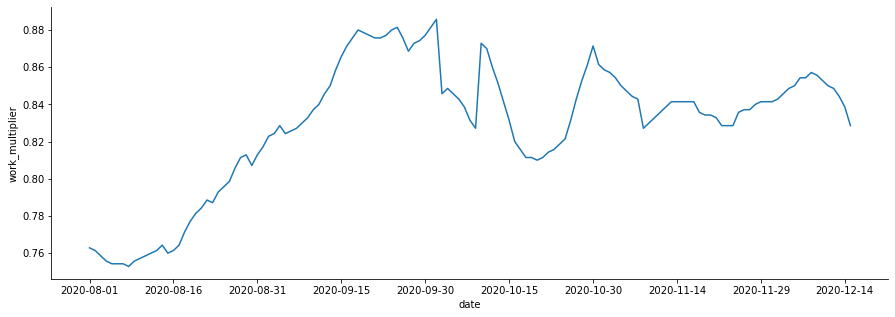

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=df.index, y=df["work_multiplier"], ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))